# Recovery of gold from ore

We need to preprocess a prototype of a machine learning model for the "Digit". The company develops solutions for the efficient operation of industrial enterprises.

The model should predict the recovery rate of gold from gold-bearing ore.

The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

Need:

- Prepare the data;
- Conduct a research analysis of the data;
- Build and train a model.

## Data description

**Technological process**

- `Rougher feed` — raw materials
- `Rougher additives` (or reagent additives) — flotation reagents: Xanthate, Sulfate, Depressant
- `Xanthate **`— xanthogenate (promoter, or flotation activator);
- `Sulfate` — sulfate (in this production sodium sulfide);
- `Depressant` — depressant (sodium silicate).
- `Rougher process` (English "rough process") — flotation
- `Rougher tails` — dump tails
- `Float banks` — flotation plant
- `Cleaner process` — cleaning
- `Rougher Au` — rough gold concentrate
- `Final Au` — final gold concentrate


**Parameters**

- `air amount stages` — air volume
- `fluid levels` — liquid level
- `feed size` — the size of the raw material granules
- `feed rate` — feed rate

**Name of features**

The name of the signs should be as follows:

`[stage].[parameter type].[parameter name]`

Example: `rougher.input.feed_aggregator`

## Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

In [2]:
data_full = pd.read_csv('gold_recovery_full_new.csv')
data_train = pd.read_csv('gold_recovery_train_new.csv')
data_test = pd.read_csv('gold_recovery_test_new.csv')

In [3]:
data_full['date'] = pd.to_datetime(data_train['date'], format="%Y-%m-%d %H:%M:%S")
data_train['date'] = pd.to_datetime(data_train['date'], format="%Y-%m-%d %H:%M:%S")
data_test['date'] = pd.to_datetime(data_train['date'], format="%Y-%m-%d %H:%M:%S")

In [4]:
# drop NaN's
data_full = data_full.dropna()
data_train = data_train.dropna()
data_test = data_test.dropna()

In [5]:
# check duplicates
lst = [data_full, data_train, data_test]
for i in lst:
    print(i.duplicated().sum())

0
0
0


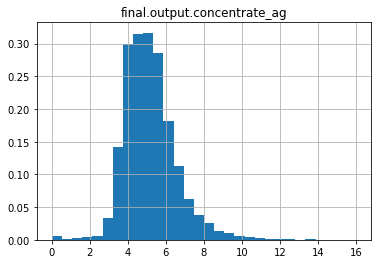

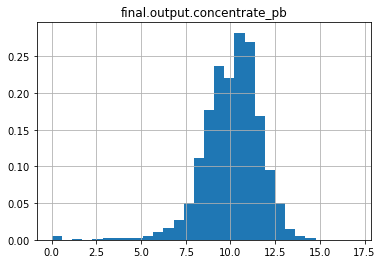

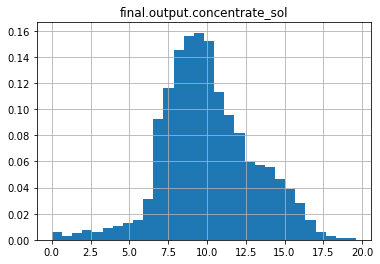

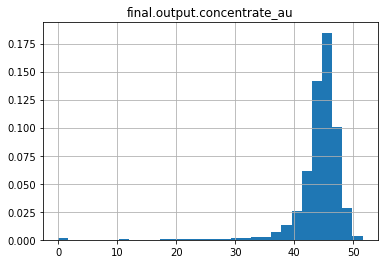

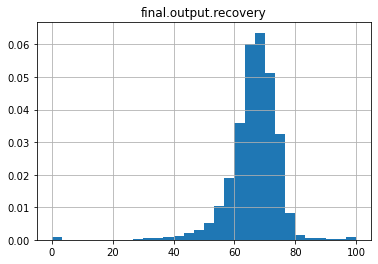

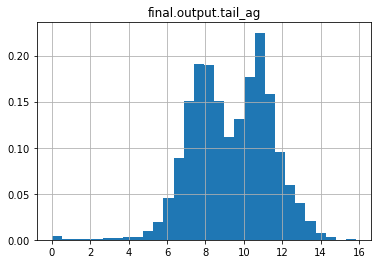

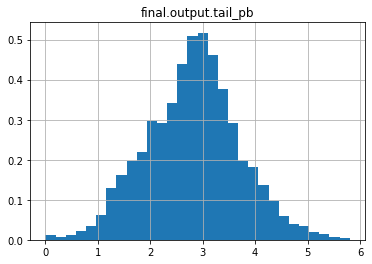

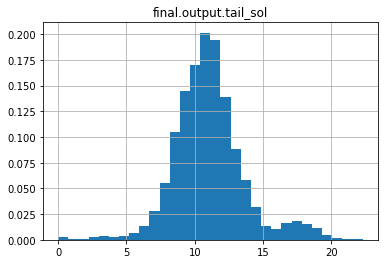

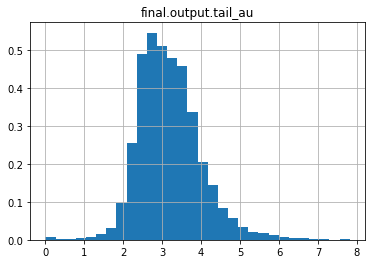

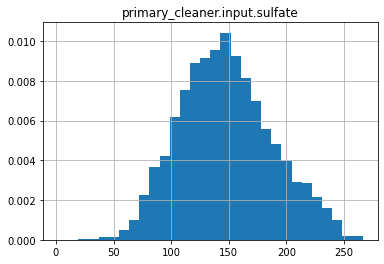

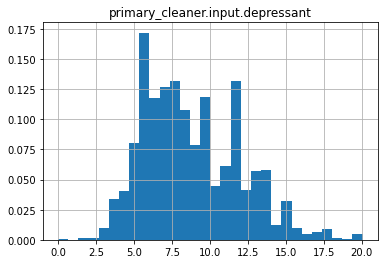

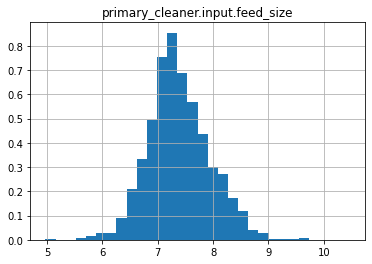

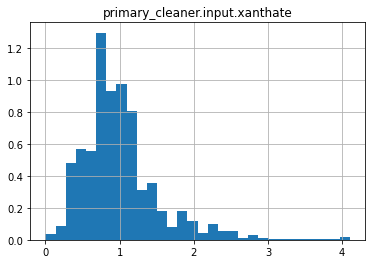

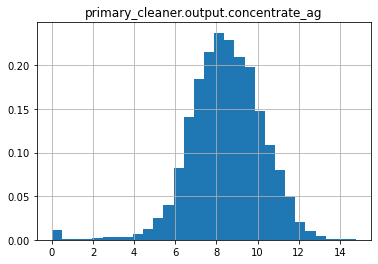

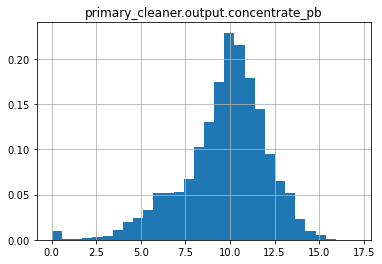

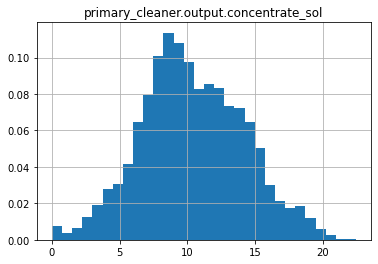

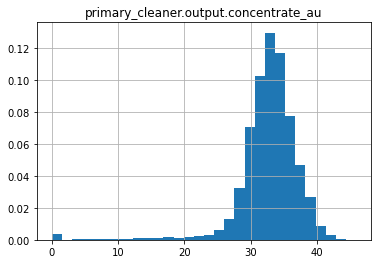

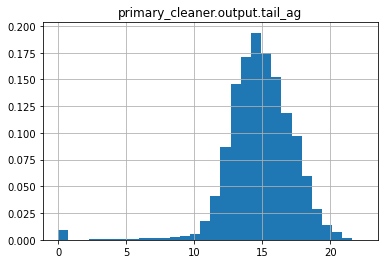

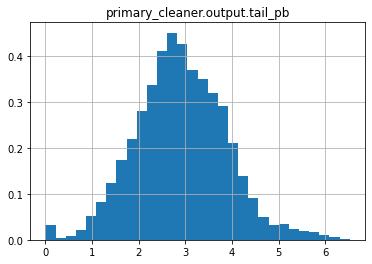

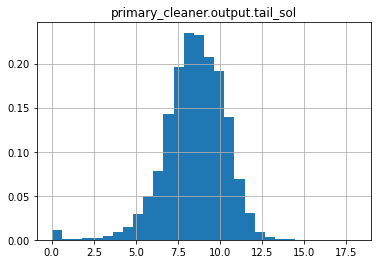

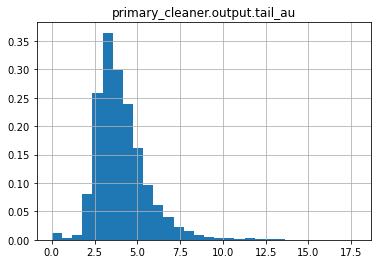

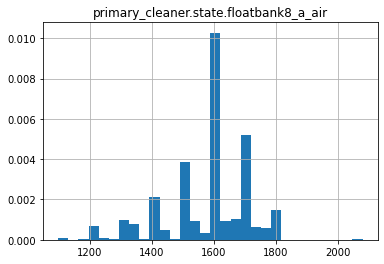

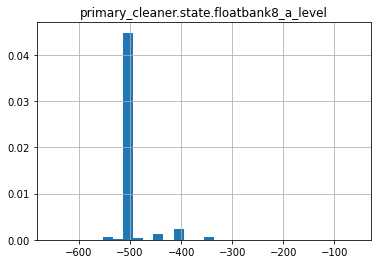

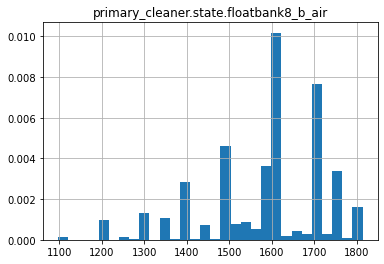

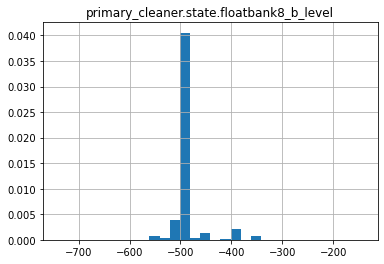

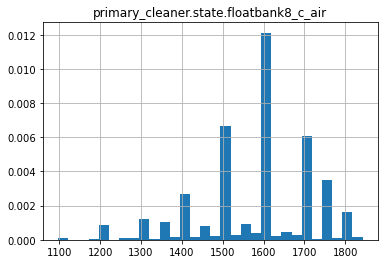

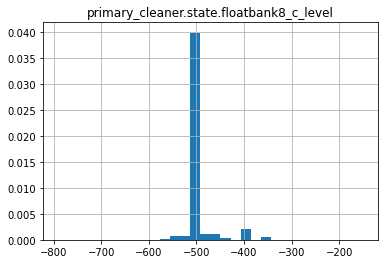

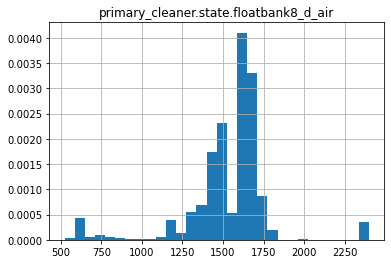

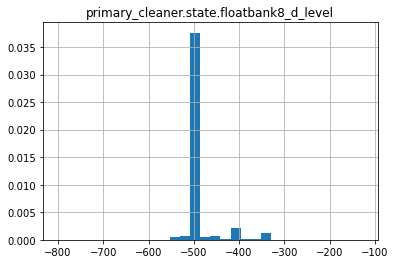

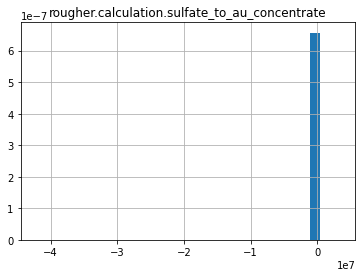

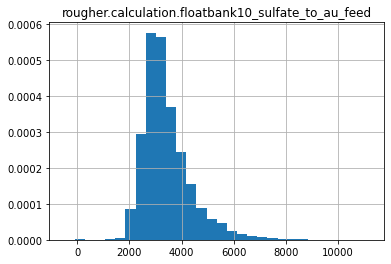

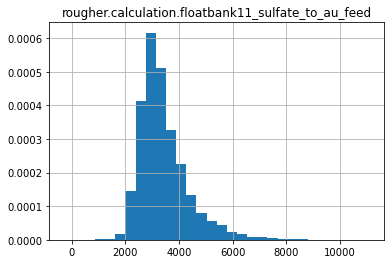

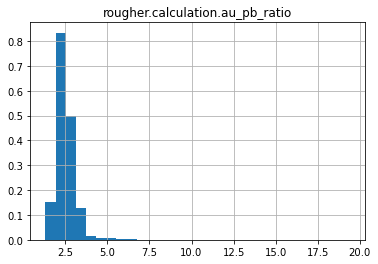

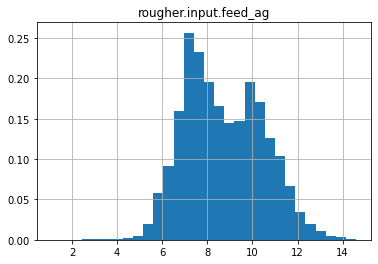

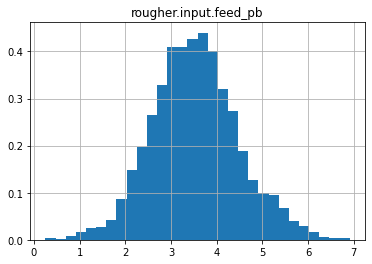

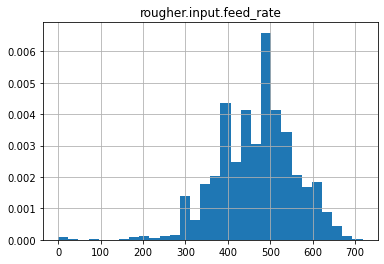

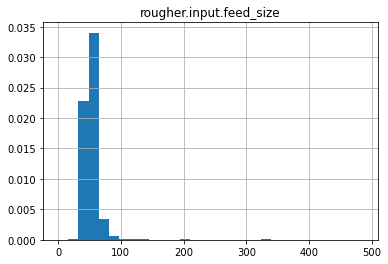

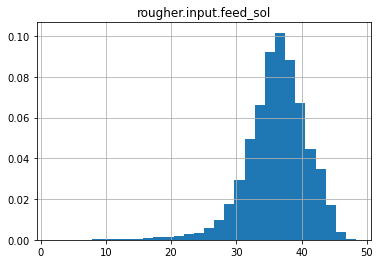

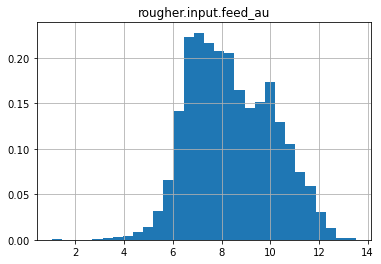

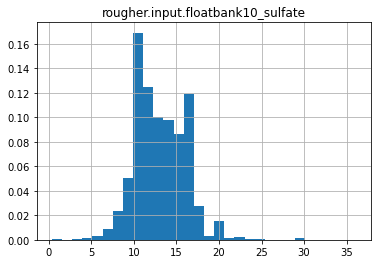

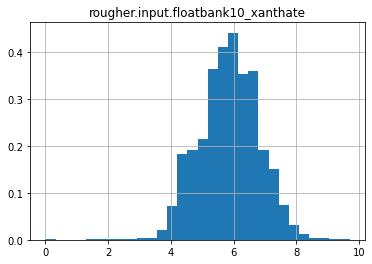

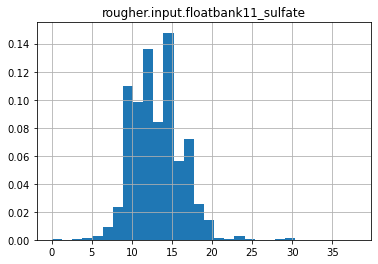

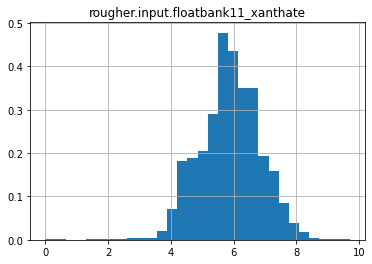

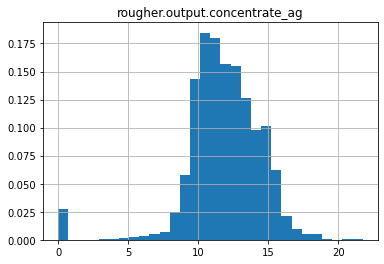

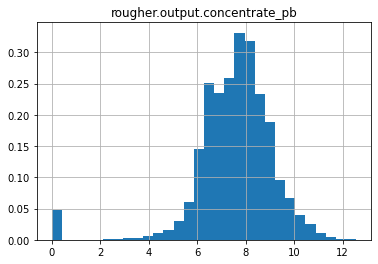

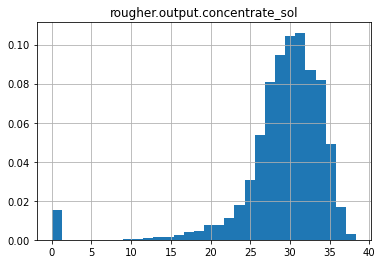

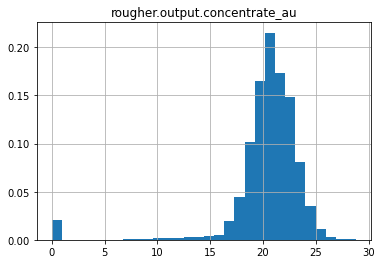

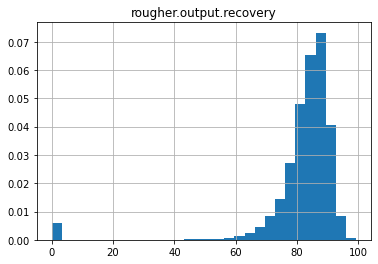

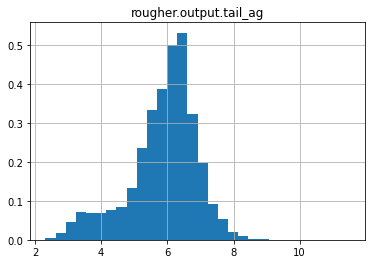

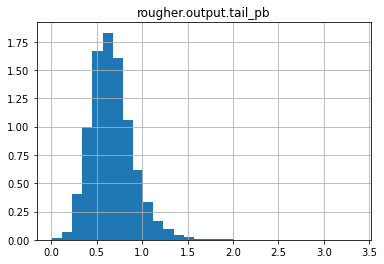

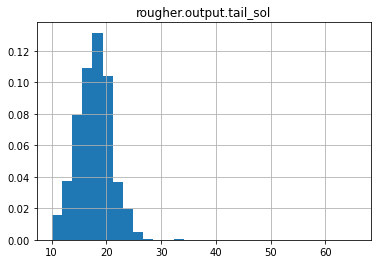

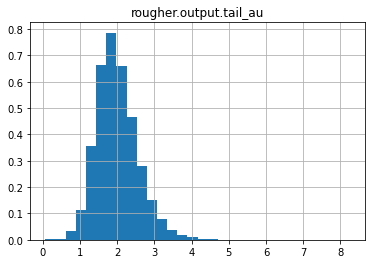

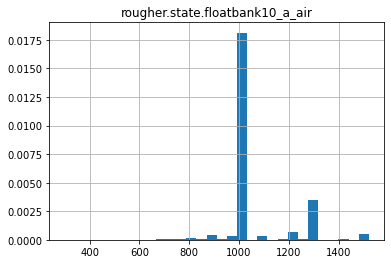

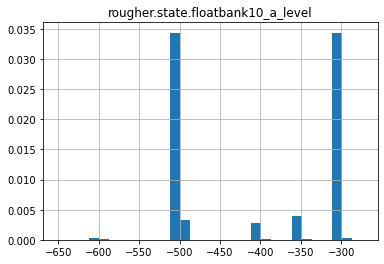

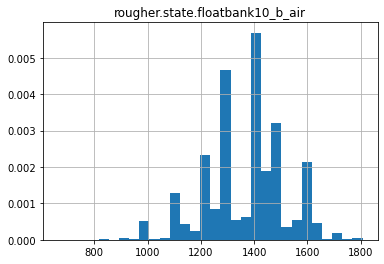

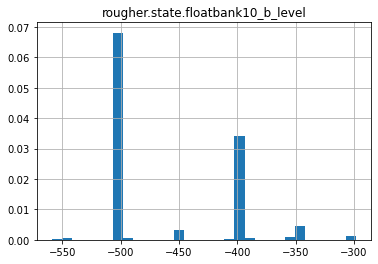

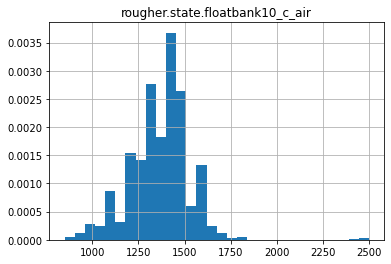

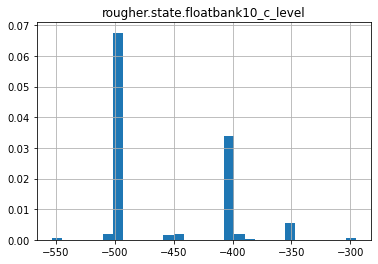

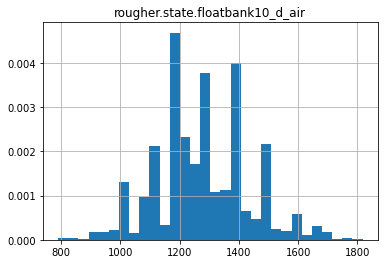

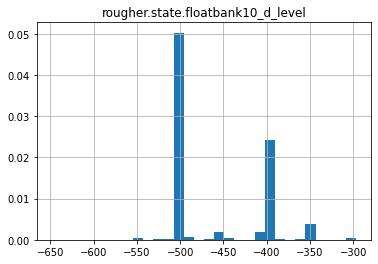

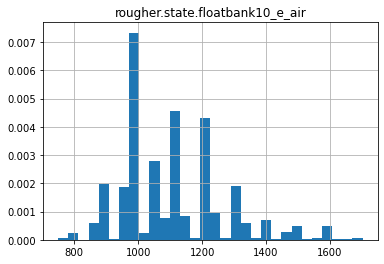

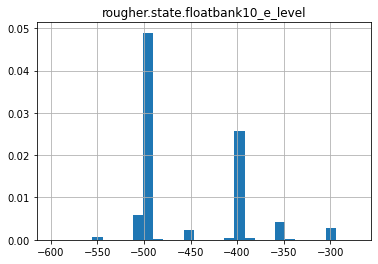

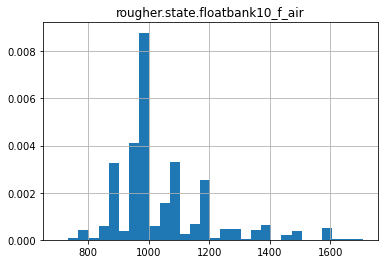

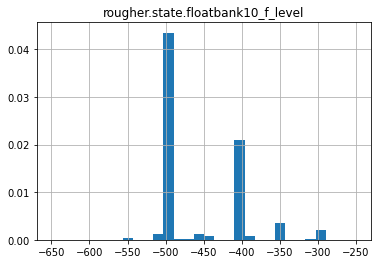

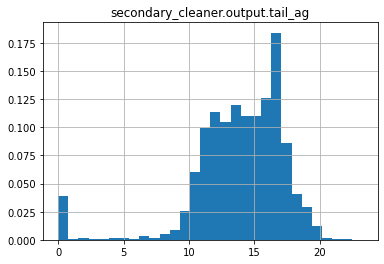

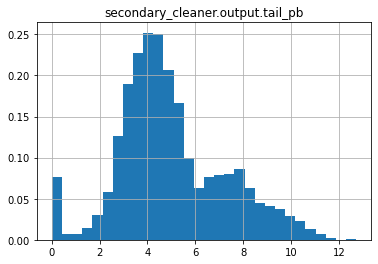

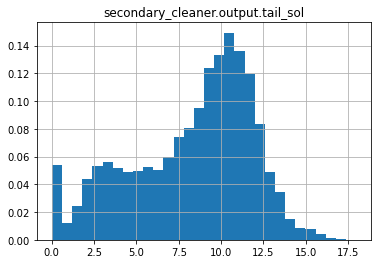

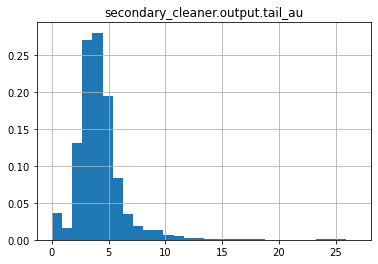

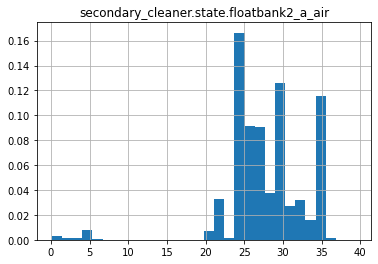

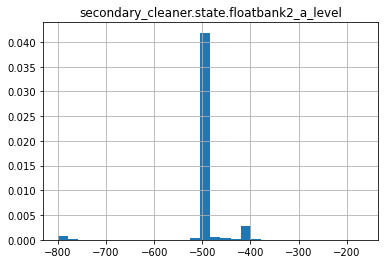

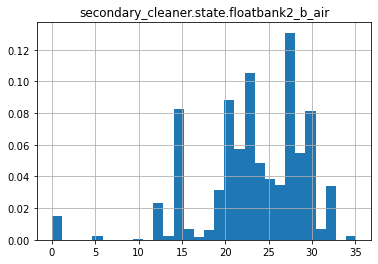

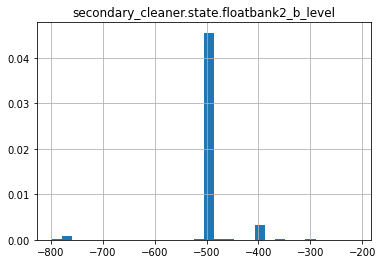

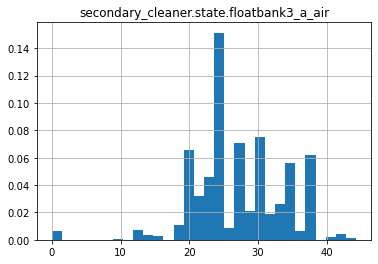

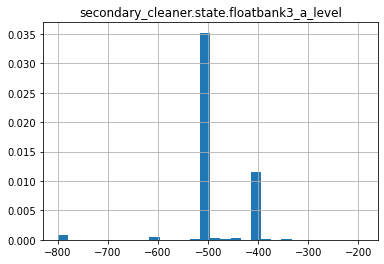

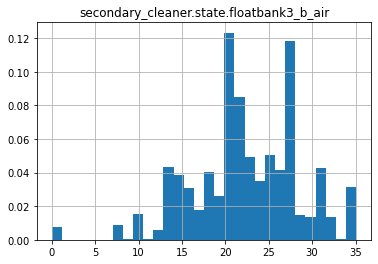

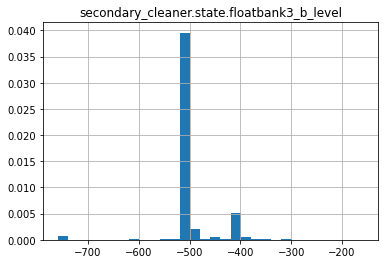

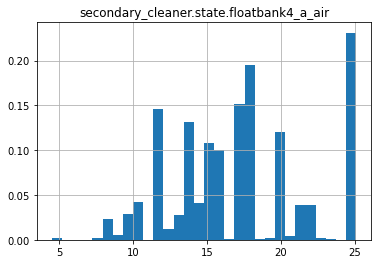

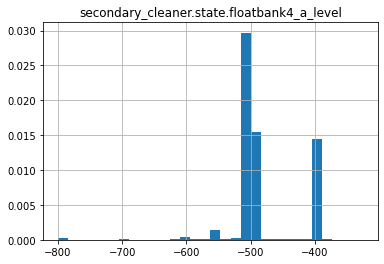

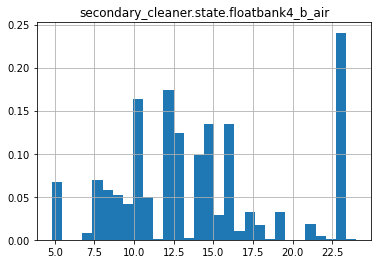

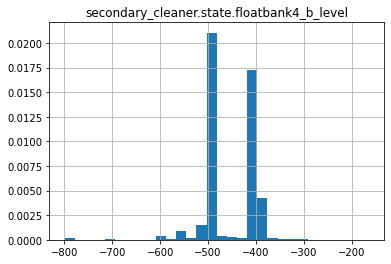

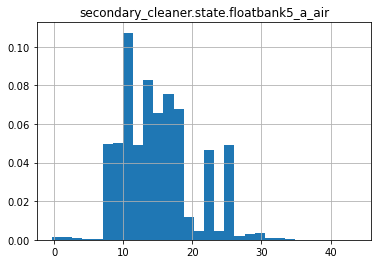

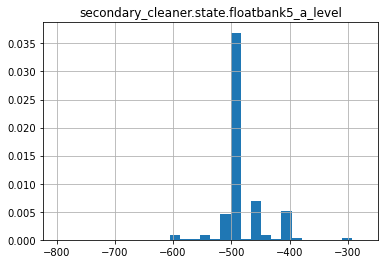

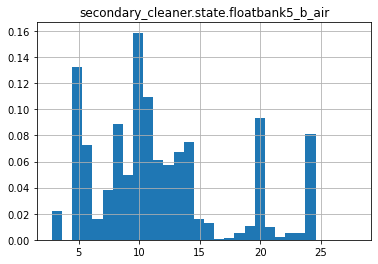

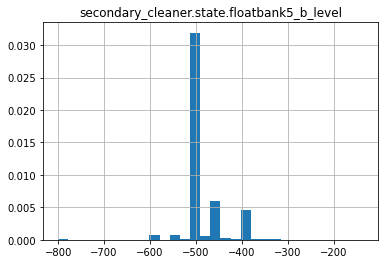

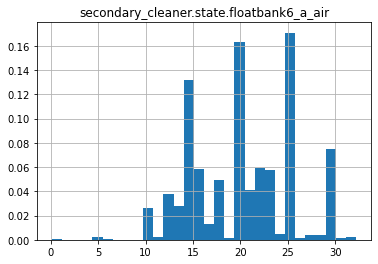

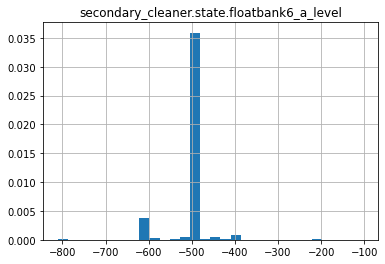

In [6]:
# plot histograms 
for i in data_full:
    if i != 'date':
        data_full[i].hist(bins=30,density=True)
        plt.title(i)
        plt.show()

In [7]:
# number missing features in data_test relatively data_train
not_availability = []
for i in data_train.columns:
    if i not in data_test.columns:
        not_availability.append(i)
print('Number of missing features in data_test = ', len(not_availability))
print()
print(pd.Series(not_availability))       

Number of missing features in data_test =  34

0                           final.output.concentrate_ag
1                           final.output.concentrate_pb
2                          final.output.concentrate_sol
3                           final.output.concentrate_au
4                                 final.output.recovery
5                                  final.output.tail_ag
6                                  final.output.tail_pb
7                                 final.output.tail_sol
8                                  final.output.tail_au
9                 primary_cleaner.output.concentrate_ag
10                primary_cleaner.output.concentrate_pb
11               primary_cleaner.output.concentrate_sol
12                primary_cleaner.output.concentrate_au
13                       primary_cleaner.output.tail_ag
14                       primary_cleaner.output.tail_pb
15                      primary_cleaner.output.tail_sol
16                       primary_cleaner.output.tail_au
1

In [8]:
# a = data_train[['final.output.recovery','rougher.output.recovery','final.output.concentrate_au','final.output.tail_au','rougher.output.tail_au','rougher.output.concentrate_au','rougher.input.feed_au']].copy() 
# display(a)



In [9]:
# enrichment efficiency of the FINAL concentrate

C_final = data_train['final.output.concentrate_au'] # share of gold in concentrate after flotation/refining
F_final = data_train['rougher.input.feed_au']       # share of gold in material before flotation/refining
T_final = data_train['final.output.tail_au']        # share of gold in waste tailings after flotation/refining
        
data_train['final_recovery'] = ((C_final * (F_final - T_final)) / (F_final * (C_final - T_final))) * 100
print('difference between the averages of the FINAL concentrate = ',data_train['final_recovery'].mean()- data_train['final.output.recovery'].mean())

difference between the averages of the FINAL concentrate =  0.0


In [10]:
# Efficiency of Rough Concentrate enrichment

C_rougher = data_train['rougher.output.concentrate_au'] # share of gold in concentrate after flotation/refining
F_rougher = data_train['rougher.input.feed_au']         # share of gold in material before flotation/refining
T_rougher = data_train['rougher.output.tail_au']        # share of gold in waste tailings after flotation/refining

data_train['rougher_recovery'] = ((C_rougher * (F_rougher - T_rougher)) / (F_rougher * (C_rougher - T_rougher))) * 100
print('difference of average ROUGH concentrate = ',data_train['rougher_recovery'].mean()- data_train['rougher.output.recovery'].mean())

difference of average ROUGH concentrate =  1.4210854715202004e-14


In [11]:
# adding "rougher.output.recovery" and "final.output.recovery" to the test features
data = data_train[['date','final.output.recovery','rougher.output.recovery']]
data_test = data.merge(data_test,how='inner',on='date')

In [12]:
# MAE between calculations and characteristic value
print(mean_absolute_error(data_train['rougher.output.recovery'], data_train['rougher_recovery']))

9.82970122149377e-15


- The training data consists of 87 columns and 14149 terms;

- The test data consists of 53 columns and 5290 rows;

- Total data includes 87 columns and 19439 rows;

- the enrichment efficiency of the ROUGH concentrate is calculated correctly:
      - MAE minimum;
      - The difference of averages is zero.
    
- The test data lacks the enrichment efficiency of the FINAL concentrate (final.output.recovery) as well as all data on the output product (data with the .output thread);

- output (output) and calculated (calculation) characteristics cannot be used in training as they will not be available by the time the process starts.


(some parameters are not available because they are measured and/or calculated much later)

## EDA

In [13]:
# a function that takes a column as input and returns the boundaries of the "whiskers"
def get_whiskers(data,column):
    descr = data[column].describe()
    
    # interquartile range
    iqr = descr[6] - descr[4]
      
    left_whisker = round(descr[4] - 1.5 * iqr, 2)
    right_whisker = round(descr[6] + 1.5 * iqr, 2)

    # left "whisker" should not be less than the minimum value
    if left_whisker < descr[3]: left_whisker = descr[3] 
        
    # right "whisker" should not be more than the maximum value
    if right_whisker > descr[7]: right_whisker = descr[7]
        
    #return (f'{column}, left whisker: {left_whisker}, right whisker: {right_whisker}')
    return [left_whisker, right_whisker]

According to the constructed diagrams it can be seen that the concentration of Au and Pb tends to increase at each stage of purification while the content of Ag on the contrary decreases.

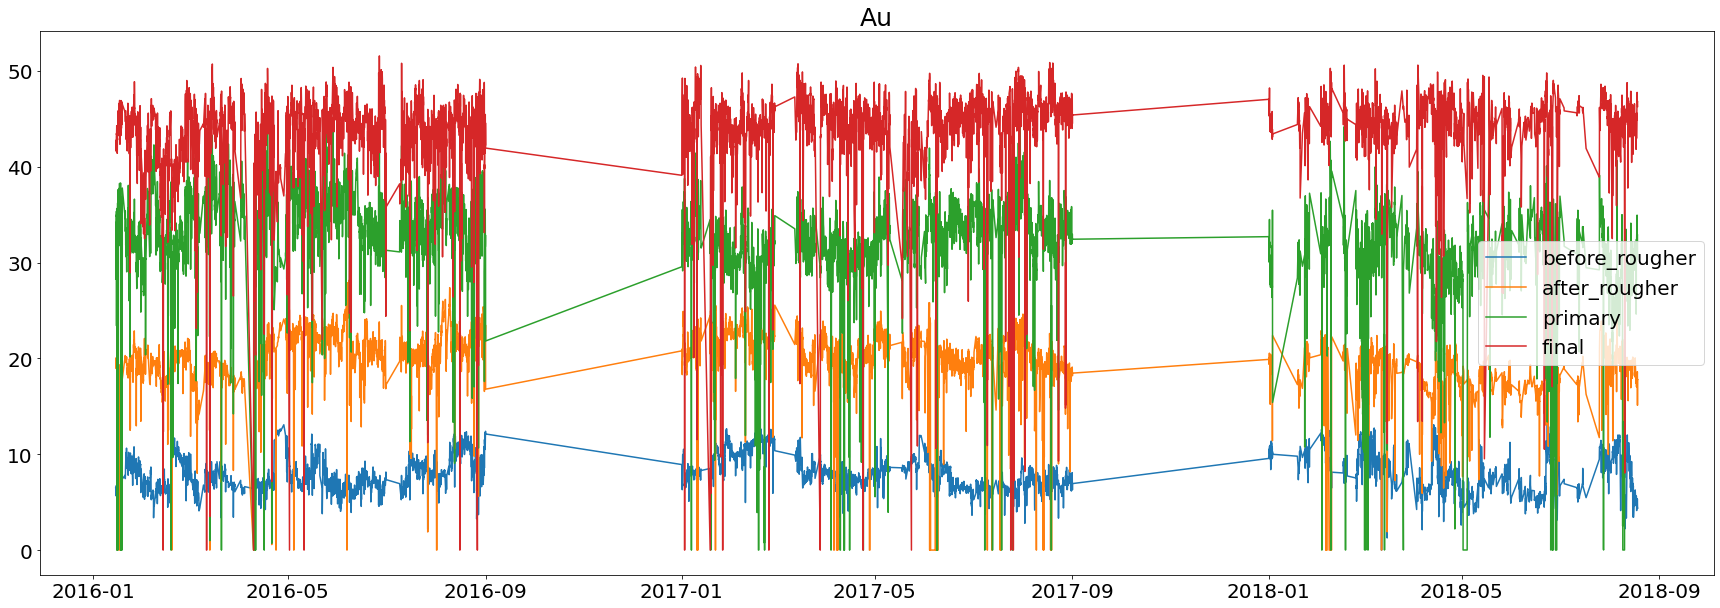

In [14]:
# Au concentration altering
aurum = ['rougher.input.feed_au','rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']
legend = ['before_rougher', 'after_rougher', 'primary','final']
plt.figure(figsize=(30, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.plot(data_train['date'], data_train[aurum].to_numpy())
plt.rc('legend', fontsize=20)
plt.legend(legend)
plt.title('Au', fontsize=25)
plt.show()

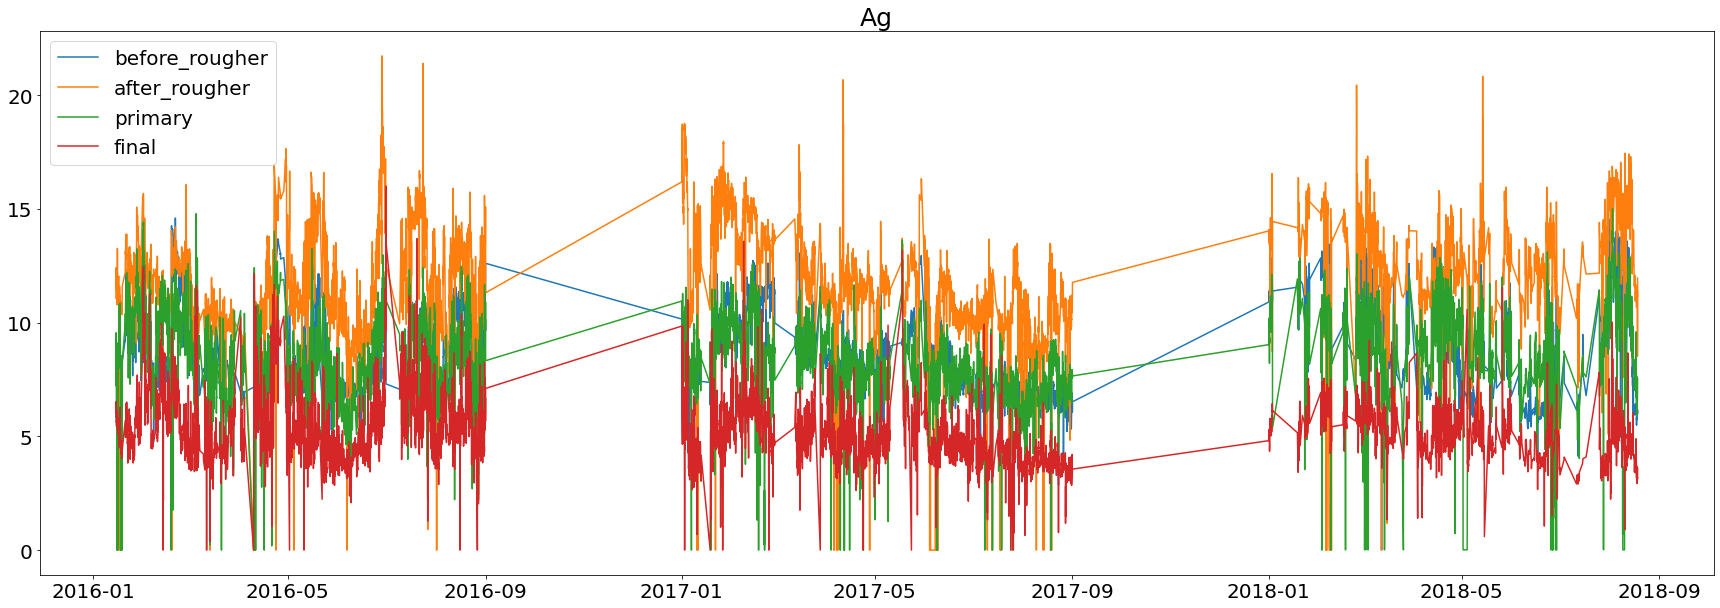

In [15]:
# Ag concentration altering
aurum = ['rougher.input.feed_ag','rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']
legend = ['before_rougher', 'after_rougher', 'primary','final']
plt.figure(figsize=(30, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.plot(data_train['date'], data_train[aurum].to_numpy())
plt.rc('legend', fontsize=20)
plt.legend(legend)
plt.title('Ag', fontsize=25)
plt.show()

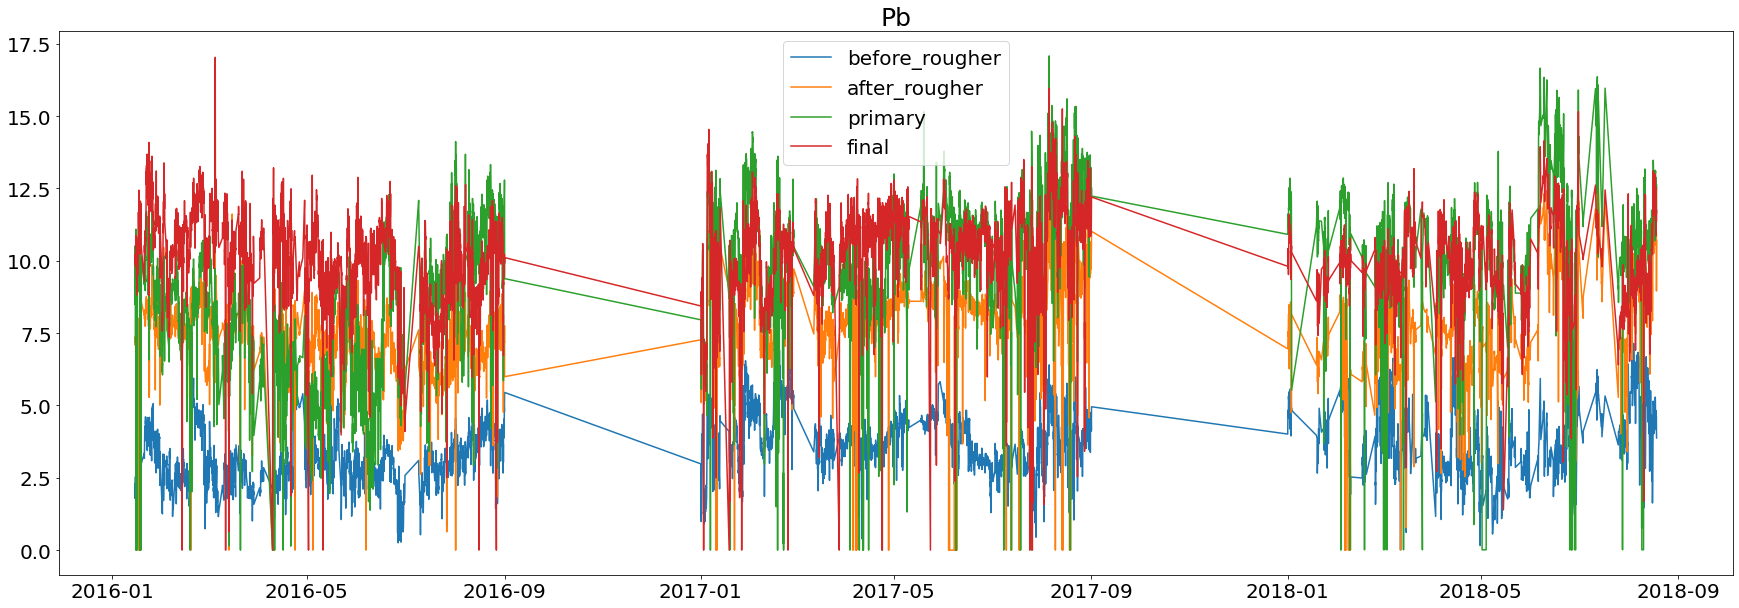

In [16]:
# Pb concentration altering
aurum = ['rougher.input.feed_pb','rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']
legend = ['before_rougher', 'after_rougher', 'primary','final']
plt.figure(figsize=(30, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.plot(data_train['date'], data_train[aurum].to_numpy())
plt.rc('legend', fontsize=20)
plt.legend(legend)
plt.title('Pb', fontsize=25)
plt.show()

There is a difference in the size of the granules.

It can be seen that the values in the test sample are distibuted around 50 and in the training sample there are many values in the range of 50 - 60.

0    primary_cleaner.input.feed_size
1            rougher.input.feed_size
dtype: object
0    primary_cleaner.input.feed_size
1            rougher.input.feed_size
dtype: object


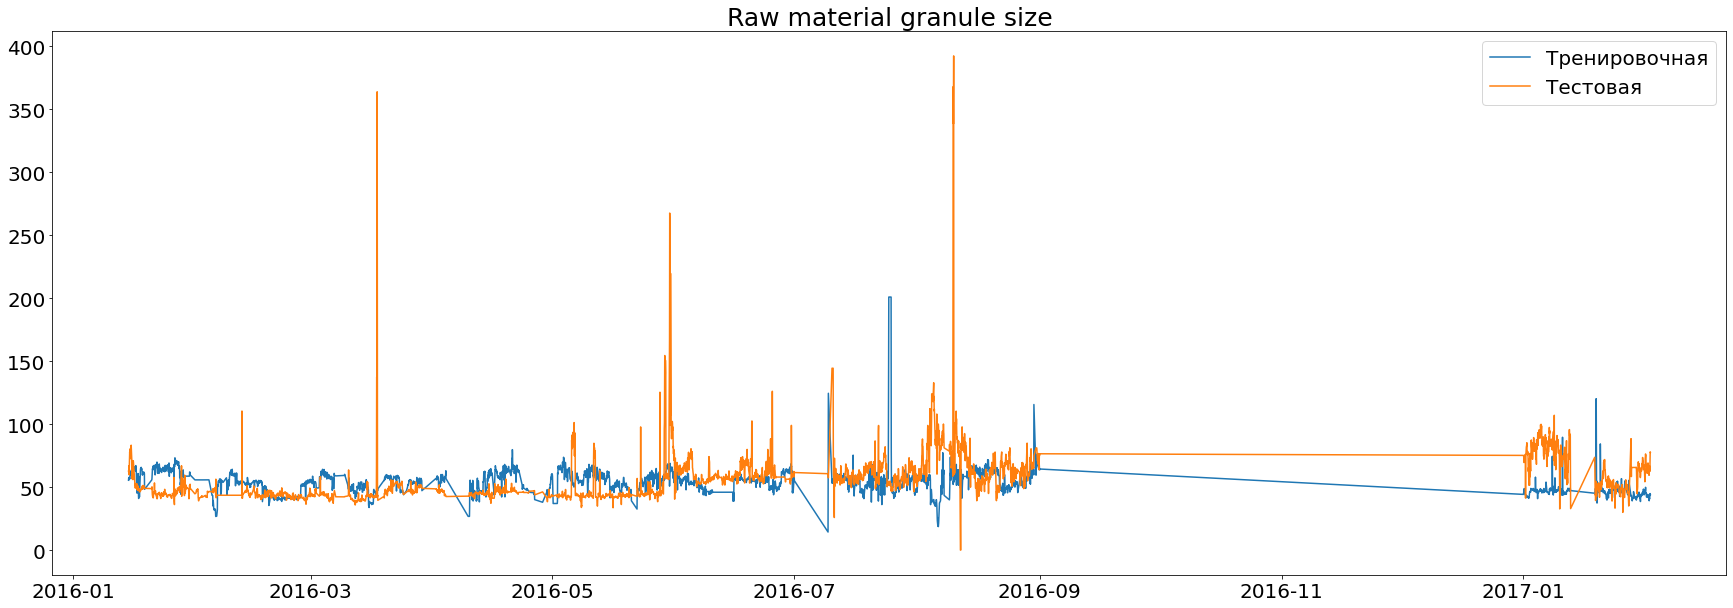

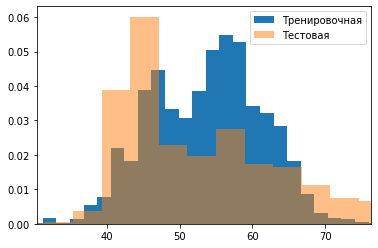

Median in test: 51.27650019776327
Median in training: 54.35489695837068


In [17]:
# features where the size of the granules from the test and training samples is stored
train_feed_size_dict = []
for i in data_train.columns:
    if 'feed_size' in i:
        train_feed_size_dict.append(i)
print(pd.Series(train_feed_size_dict)) 

test_feed_size_dict = []
for i in data_test.columns:
    if 'feed_size' in i:
        test_feed_size_dict.append(i)
print(pd.Series(test_feed_size_dict)) 

# объединение таблиц
train = data_train[['date','rougher.input.feed_size']].copy()
test = data_test[['date','rougher.input.feed_size']].copy()
overall_feed_size = train.merge(test, how='inner', on='date')
overall_feed_size.columns = ['date','Тренировочная','Тестовая']

# plot diagrams with granul size
a = overall_feed_size.columns[1:]
plt.figure(figsize=(30, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.plot(overall_feed_size['date'], overall_feed_size[a].to_numpy())
plt.rc('legend', fontsize=20)
plt.legend(a)
plt.title('Raw material granule size', fontsize=25)
plt.show()

# plot histograms
plt.hist(overall_feed_size['Тренировочная'], bins=100, alpha=1, label='Тренировочная', density=True)
plt.hist(overall_feed_size['Тестовая'], bins=100, alpha=0.5, label='Тестовая', density=True)
plt.xlim(get_whiskers(overall_feed_size,'Тренировочная')[0],get_whiskers(overall_feed_size,'Тренировочная')[1])
plt.rc('legend', fontsize=10)
plt.legend(loc='upper right')
plt.show()

# use median due to outlier
print('Median in test:',overall_feed_size['Тестовая'].median())
print('Median in training:',overall_feed_size['Тренировочная'].median())

All distributions have a peak near zero. It is very far from the general distribution it should be removed.

0     rougher.output.concentrate_ag
1     rougher.output.concentrate_pb
2    rougher.output.concentrate_sol
3     rougher.output.concentrate_au
dtype: object
0     primary_cleaner.output.concentrate_ag
1     primary_cleaner.output.concentrate_pb
2    primary_cleaner.output.concentrate_sol
3     primary_cleaner.output.concentrate_au
dtype: object
0     final.output.concentrate_ag
1     final.output.concentrate_pb
2    final.output.concentrate_sol
3     final.output.concentrate_au
dtype: object


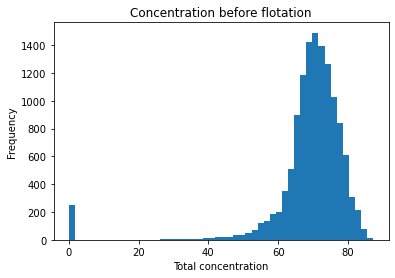

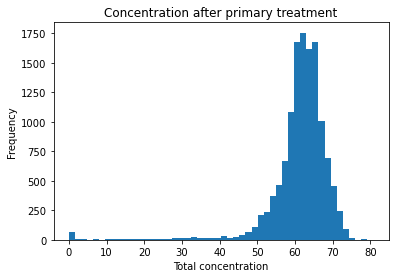

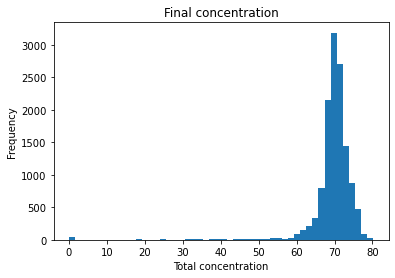

Use get_whikers


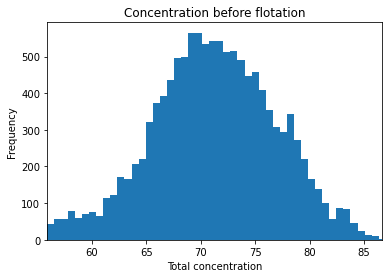

C:\Users\leint\AppData\Local\Temp\ipykernel_8908\489904339.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_full['sum_conc'] = data_full[i].sum(axis=1)


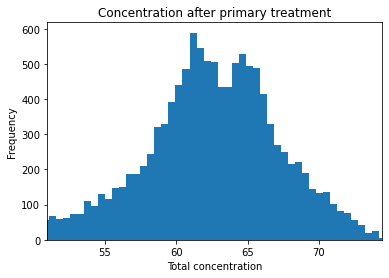

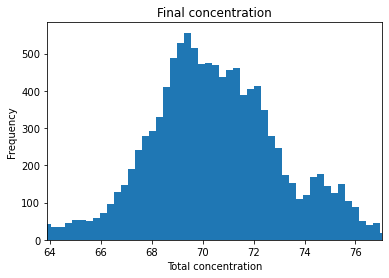

In [18]:
# features that store the concentration of all substances at different stages from data_full
rougher = []
primary_cleaner = []
final = []
overal_concentrations = [rougher,primary_cleaner,final]
overal_concentrations_id = ['Concentration before flotation', 'Concentration after primary treatment', 'Final concentration']


for i in data_full.columns:
    if 'concentrate_' in i:
        if 'rougher' in i:
            rougher.append(i)
        elif 'primary_cleaner' in i:
            primary_cleaner.append(i)
        elif 'final' in i:
            final.append(i)
            
print(pd.Series(rougher))
print(pd.Series(primary_cleaner))
print(pd.Series(final))

# initial data histogram 
for i, y in zip(overal_concentrations,overal_concentrations_id):
    data_full['sum_conc'] = data_full[i].sum(axis=1)
    plt.hist(data_full['sum_conc'], bins=50)
    plt.rc('legend', fontsize=10)
    plt.title(y)
    plt.xlabel('Total concentration')
    plt.ylabel('Frequency')
    plt.show()
print('Use get_whikers')

# histogram with using function get_whiskers for data_full
for i,y in zip(overal_concentrations,overal_concentrations_id):
    data_full['sum_conc'] = data_full[i].sum(axis=1)
    data_full = data_full.loc[(data_full['sum_conc'] >= get_whiskers(data_full,'sum_conc')[0]) & (data_full['sum_conc'] <= get_whiskers(data_full,'sum_conc')[1])]
    plt.hist(data_full['sum_conc'], bins=50)
    plt.rc('legend', fontsize=10)
    plt.xlim(get_whiskers(data_full,'sum_conc')[0], get_whiskers(data_full,'sum_conc')[1])
    plt.title(y)
    plt.xlabel('Total concentration')
    plt.ylabel('Frequency')
    plt.show()

0     rougher.output.concentrate_ag
1     rougher.output.concentrate_pb
2    rougher.output.concentrate_sol
3     rougher.output.concentrate_au
dtype: object
0     primary_cleaner.output.concentrate_ag
1     primary_cleaner.output.concentrate_pb
2    primary_cleaner.output.concentrate_sol
3     primary_cleaner.output.concentrate_au
dtype: object
0     final.output.concentrate_ag
1     final.output.concentrate_pb
2    final.output.concentrate_sol
3     final.output.concentrate_au
dtype: object


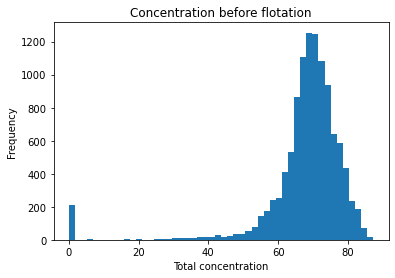

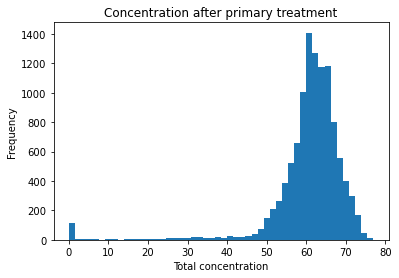

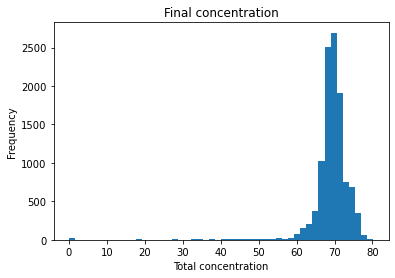

Use get_whikers


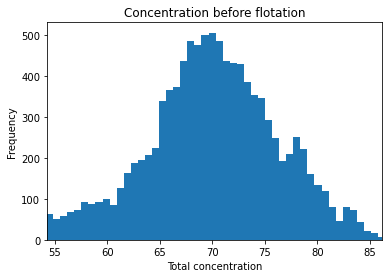

C:\Users\leint\AppData\Local\Temp\ipykernel_8908\4217082462.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['sum_conc'] = data_train[i].sum(axis=1)


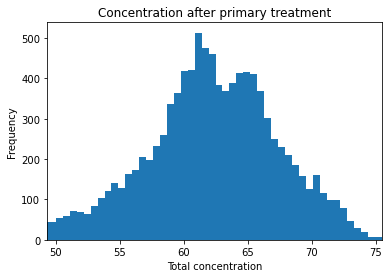

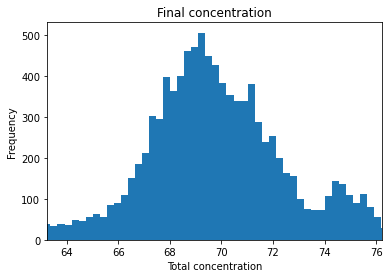

In [19]:
# features that store the concentration of all substances at different stages from data_train
rougher = []
primary_cleaner = []
final = []
overal_concentrations = [rougher,primary_cleaner,final]
overal_concentrations_id = ['Concentration before flotation', 'Concentration after primary treatment', 'Final concentration']


for i in data_train.columns:
    if 'concentrate_' in i:
        if 'rougher' in i:
            rougher.append(i)
        elif 'primary_cleaner' in i:
            primary_cleaner.append(i)
        elif 'final' in i:
            final.append(i)
            
print(pd.Series(rougher))
print(pd.Series(primary_cleaner))
print(pd.Series(final))

# initial data histogram
for i,y in zip(overal_concentrations,overal_concentrations_id):
    data_train['sum_conc'] = data_train[i].sum(axis=1)
    plt.hist(data_train['sum_conc'], bins=50)
    plt.rc('legend', fontsize=10)
    plt.title(y)
    plt.xlabel('Total concentration')
    plt.ylabel('Frequency')
    plt.show()
print('Use get_whikers')

# histogram with using function get_whiskers for data_full
for i,y in zip(overal_concentrations,overal_concentrations_id):
    data_train['sum_conc'] = data_train[i].sum(axis=1)
    data_train = data_train.loc[(data_train['sum_conc'] >= get_whiskers(data_train,'sum_conc')[0]) & (data_train['sum_conc'] <= get_whiskers(data_train,'sum_conc')[1])]
    plt.hist(data_train['sum_conc'], bins=50)
    plt.rc('legend', fontsize=10)
    plt.xlim(get_whiskers(data_train,'sum_conc')[0], get_whiskers(data_train,'sum_conc')[1])
    plt.title(y)
    plt.xlabel('Total concentration')
    plt.ylabel('Frequency')
    plt.show()

In [20]:
data_full = data_full.loc[(data_full['final.output.recovery'] >= get_whiskers(data_full,'final.output.recovery')[0])\
                          & (data_full['final.output.recovery'] <= get_whiskers(data_full,'final.output.recovery')[1])]

data_test = data_test.loc[(data_test['final.output.recovery'] >= get_whiskers(data_test,'final.output.recovery')[0])\
                          & (data_test['final.output.recovery'] <= get_whiskers(data_test,'final.output.recovery')[1])]

data_train = data_train.loc[(data_train['final.output.recovery'] >= get_whiskers(data_train,'final.output.recovery')[0])\
                            & (data_train['final.output.recovery'] <= get_whiskers(data_train,'final.output.recovery')[1])]

data_full = data_full.loc[(data_full['rougher.output.recovery'] >= get_whiskers(data_full,'rougher.output.recovery')[0])\
                          & (data_full['rougher.output.recovery'] <= get_whiskers(data_full,'rougher.output.recovery')[1])]

data_test = data_test.loc[(data_test['rougher.output.recovery'] >= get_whiskers(data_test,'rougher.output.recovery')[0])\
                          & (data_test['rougher.output.recovery'] <= get_whiskers(data_test,'rougher.output.recovery')[1])]

data_train = data_train.loc[(data_train['rougher.output.recovery'] >= get_whiskers(data_train,'rougher.output.recovery')[0])\
                            & (data_train['rougher.output.recovery'] <= get_whiskers(data_train,'rougher.output.recovery')[1])]

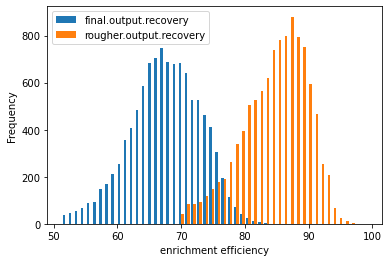

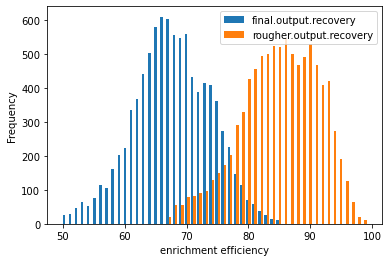

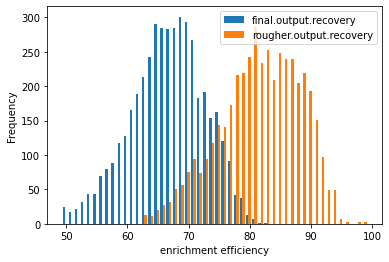

In [21]:
data_all = [data_full, data_train, data_test]
l = [['final.output.recovery','rougher.output.recovery']]

# histogram
for y in data_all:
    for i in l:
        plt.hist(y[i], bins=50)
        plt.rc('legend', fontsize=10)
        plt.legend(['final.output.recovery','rougher.output.recovery'])
        plt.xlabel('enrichment efficiency')
        plt.ylabel('Frequency')
        plt.show()

## Model training

In [22]:
# Function to calculate sMAPE
def sMAPE(y_true, y_pred):
    error = np.mean(abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)) / 2)) * 100
    return error

In [23]:
# Function to calculate the final sMAPE
def final_sMAPE(sMAPE_rougher, sMAPE_final):
    return ((0.25 * sMAPE_rougher) + (0.75 * sMAPE_final))

In [24]:
# deleting columns that are not in the test set for training

feature_train = data_full.drop(['date','sum_conc'], axis=1)
feature_train = feature_train.drop(not_availability, axis=1)
target_train_rougher_i = data_full['rougher.output.recovery']
target_train_final_i = data_full['final.output.recovery']

# TEST sample

feature_test = data_test.drop(['final.output.recovery','rougher.output.recovery','date'], axis=1)
target_test_f = data_test['final.output.recovery']
target_test_r = data_test['rougher.output.recovery']

In [25]:
feature_train_final, feature_valid_final, target_train_final, target_valid_final = train_test_split(feature_train,
                                                                                                    target_train_final_i,
                                                                                                    test_size=0.25, 
                                                                                                    random_state=12345)

feature_train_rougher, feature_valid_rougher, target_train_rougher, target_valid_rougher = train_test_split(feature_train,
                                                                                                    target_train_rougher_i,
                                                                                                    test_size=0.25, 
                                                                                                    random_state=12345)

In [26]:
# DecisionTreeRegressor Model 

start_time = time.time()

model_tree_final = None
model_tree_rougher = None


# final
model_tree_f = DecisionTreeRegressor(max_depth=12, random_state=12345)
# perform cross validation
scores = cross_val_score(model_tree_f, feature_train, target_train_final_i, cv=5)
final_score_f = sum(scores) / len(scores)
# fit model
model_tree_f = model_tree_f.fit(feature_train_final, target_train_final)
prediction_f = model_tree_f.predict(feature_valid_final)
# save model
model_tree_final = model_tree_f
# error calculation
smape_f = sMAPE(target_valid_final,prediction_f)

# rougher
model_tree_r = DecisionTreeRegressor(max_depth=11, random_state=12345)
# perform cross validation
scores = cross_val_score(model_tree_r, feature_train, target_train_rougher_i, cv=5)
final_score_r = sum(scores) / len(scores)
# fit model
model_tree_r = model_tree_r.fit(feature_train_rougher, target_train_rougher)
prediction_r = model_tree_r.predict(feature_valid_rougher)
# save model
model_tree_rougher = model_tree_r
# error calculation
smape_r = sMAPE(target_valid_rougher,prediction_r)

# final error calculation
final_sMAPE1 = final_sMAPE(smape_r,smape_f)

print('final_sMAPE',final_sMAPE1)
print("--- %s seconds ---" % (time.time() - start_time))
print('final_score_f',final_score_f)
print('final_score_r',final_score_r)

final_sMAPE 4.28707419143712
--- 2.956230640411377 seconds ---
final_score_f -1.0043531621882575
final_score_r -1.0333991309456074


In [27]:
# RandomForestRegressor model

start_time = time.time()
model_random_forest_final = None
model_random_forest_rougher = None

smape_f = np.inf
smape_r = np.inf
tree_f = 0
depth_f = 0
depth_r = 0
tree_r = 0
final_score_f = 0 
final_score_r = 0

for i in range(9,10): 
    for y in range(1,3):
        # final
        model_random_forest_f = RandomForestRegressor(n_estimators=i, max_depth=y, random_state=12345)
        scores = cross_val_score(model_random_forest_f, feature_train, target_train_final_i, cv=5)
        final_score = sum(scores) / len(scores)
        model_random_forest_f = model_random_forest_f.fit(feature_train_final, target_train_final)
        prediction_f = model_random_forest_f.predict(feature_valid_final)
        smape = sMAPE(target_valid_final,prediction_f)
#         print(smape)
        if smape < smape_f:
            smape_f = smape
            depth_f = y
            tree_f = i
            model_random_forest_final = model_random_forest_f
            final_score_f = final_score

#         # rougher
        model_random_forest_r = RandomForestRegressor(n_estimators=i,max_depth=y, random_state=12345)
        scores = cross_val_score(model_random_forest_f, feature_train, target_train_rougher_i, cv=5)
        final_score = sum(scores) / len(scores)
        model_random_forest_r = model_random_forest_r.fit(feature_train_rougher, target_train_rougher)
        prediction_r = model_random_forest_r.predict(feature_valid_rougher)
        smape = sMAPE(target_valid_rougher,prediction_r)
        if smape < smape_r:
            smape_r = smape
            depth_r = y
            tree_r = i
            model_random_forest_rougher = model_random_forest_r
            final_score_r = final_score

final_sMAPE1 = final_sMAPE(smape_r,smape_f)


print ('SMAPE_FINAL',smape_f)
print('depth_final',depth_f)
print('tree_counts',tree_f)
print('final_score_f',final_score_f)
print()
print ('SMAPE_rougher',smape_r)
print('depth_rougher',depth_r)
print('tree_counts',tree_r)
print('final_score_r',final_score_r)
print()
print('final_sMAPE',final_sMAPE1)
print("--- %s seconds ---" % (time.time() - start_time))
      

SMAPE_FINAL 5.64576666455153
depth_final 2
tree_counts 9
final_score_f -0.07377066010810614

SMAPE_rougher 3.59755941732265
depth_rougher 2
tree_counts 9
final_score_r -0.3089826439882377

final_sMAPE 5.13371485274431
--- 5.735997915267944 seconds ---


In [28]:
# RandomForestRegressor 9 trees и 12 depth
start_time = time.time()

model_random_forest_final = None
model_random_forest_rougher = None

# final
model_random_forest_f = RandomForestRegressor(n_estimators=9,max_depth=12, random_state=12345)
# cross validation
scores = cross_val_score(model_random_forest_f, feature_train, target_train_final_i, cv=5)
final_score_f = sum(scores) / len(scores)
# train model
model_random_forest_f = model_random_forest_f.fit(feature_train_final, target_train_final)
prediction_f = model_random_forest_f.predict(feature_valid_final)
# write the model to a variable
model_random_forest_final = model_random_forest_f
# error calculation
tree_smape_f = sMAPE(target_valid_final,prediction_f)

# rougher
model_random_forest_r = RandomForestRegressor(n_estimators=9,max_depth=11, random_state=12345)
# cross validation
scores = cross_val_score(model_random_forest_f, feature_train, target_train_rougher_i, cv=5)
final_score_r = sum(scores) / len(scores)
# train model
model_random_forest_r = model_random_forest_r.fit(feature_train_rougher, target_train_rougher)
prediction_r = model_random_forest_r.predict(feature_valid_rougher)
# write the model to a variable
model_random_forest_rougher = model_random_forest_r
# error calculation
tree_smape_r = sMAPE(target_valid_rougher,prediction_r)

# final error
final_sMAPE_tree = final_sMAPE(tree_smape_r,tree_smape_f)

print('final_sMAPE',final_sMAPE_tree)
print("--- %s seconds ---" % (time.time() - start_time))
print('final_score_f',final_score_f)
print('final_score_r',final_score_r)


final_sMAPE 3.6763807131593413
--- 15.972248077392578 seconds ---
final_score_f -0.15455802685938608
final_score_r -0.4935577006240141


In [29]:
# DummyRegressor to test
dummy_regr_rougher_final = DummyRegressor(strategy="mean")
dummy_regr_rougher_final.fit(feature_test, target_test_f)
prediction_f = dummy_regr_rougher_final.predict(feature_test)
smape_f = sMAPE(target_test_f,prediction_f)

dummy_regr_rougher = DummyRegressor(strategy="mean")
dummy_regr_rougher.fit(feature_test, target_test_r)
prediction_r = dummy_regr_rougher.predict(feature_test)
smape_r = sMAPE(target_test_r,prediction_r)

final_sMAPE1 = final_sMAPE(smape_r,smape_f)
print ('sfinal_sMAPE с DummyRegressor',final_sMAPE1)

sfinal_sMAPE с DummyRegressor 7.144832123420038


In [30]:
# testing the best model on a test set
start_time = time.time()

prediction = model_random_forest_final.predict(feature_test)
smape_f = sMAPE(target_test_f,prediction)

prediction = model_random_forest_rougher.predict(feature_test)
smape_r = sMAPE(target_test_r,prediction)

final_sMAPE = final_sMAPE(smape_r,smape_f)
print (final_sMAPE)
print("--- %s seconds ---" % (time.time() - start_time))       

8.518236620790688
--- 0.009003877639770508 seconds ---


**Conclusion:**
- The final model is consruct on the RandomForest algorithm
- Error on the test sample: 8.5 (possible overfitting)
- Algorithm parameters: Number of trees: 9, Depth: 12
- The recovery parameter in the training set was calculated correctly
- Initially, 34 features are missing in the test sample